In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re 
import nltk
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

In [2]:
# reading given stopwords
with open('stopwords_ar.txt', encoding="utf8") as file:
    words = file.readlines()
# remove \n from each line
ar_stopwords = [word[:-1] for word in words]

In [3]:
def preprocess_text(texts):
    clean_text = list()
    for text in texts:
        text = str(text)
        text = re.sub(r'\d',' ',text)    # remove digits
        text = re.sub(r'\\n',' ',text)   # remove new lines to make text as single paragraph. Backslash is used as given text is having backslash noise
        text = re.sub(r'\n',' ',text)    # remove new lines to make text as single paragraph
        text = re.sub(r'\W',' ',text)    # remove all punchuation
        text = re.sub(r'_', ' ', text)   # remove underscore(_)
        re.sub(r'[\"?.>`÷×؛<>_()*&^%ـ،/:"؟.,{}~¦+|!”…“–ـ]', ' ',text)  # remove punchuation
        text = re.sub(r'\s+',' ',text)   # remove extra whitespaces
        
        text = ' '.join(word for word in text.split() if word not in ar_stopwords)
        clean_text.append(text)
    return clean_text

### Model

In [4]:
# this function is for finding evaluation metrics of given input 
def report(prediction, y_true):
    print('        ----------Classification Report Of Classes-------------')
    print(classification_report(y_true,prediction,target_names=label_names))
    print('\n        ----------Validation Data------------------')
    print('Accuarcy:',accuracy_score(y_true, prediction)* 100)
    print('Precision: {:,.2f} %'.format(precision_score(y_true, prediction, average='weighted') * 100))
    print('Recall-score: {:,.2f}'.format(recall_score(y_true, prediction, average='weighted') * 100))
    print('F1-score: {:,.2f}'.format(f1_score(y_true, prediction, average='weighted') * 100))
    cm = confusion_matrix(y_true,prediction)
    print('\n-----------Confusion Matrix------------\n')
    print(cm)
    
    plt.imshow(cm , cmap= plt.cm.Blues_r)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks,label_names, rotation = 40)
    plt.yticks(tick_marks,label_names)
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j],'.2f'), ha='center', va='center',
                     color='black' if cm[i,j] > thresh else 'white')
    plt.show()

#### CNN Model

In [5]:
def trainmodelCNN(features, labels):
    #labels will be something like this
    #1-negative
    #2-positive
    #3-negative .. so on so fourth
    # splitting data
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size=0.3, shuffle=True, random_state=42)
    #random_state=42 -> simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.

    #Defining model
    model = Sequential() #The sequential model is a linear stack of layers, meaning we stack some layers over each others
    model.add(Dense(64,input_shape=(features.shape[1],), activation='relu'))
    #dense means full, every neural is connected to all neurals in next layer
    #this gives us the advantage of learning all the features and combinations of the prevrious layer
    

    model.add(Reshape((64,1)))
    model.add(Conv1D(32, kernel_size=3, padding='same', strides=(1)))                                                        
    #number of filters = 32
    #padding = same, means we add columns with 0 to the string, if necessarry, so we dont lose any features
    #if padding = vlaid, means we dont add columns
    model.add(MaxPooling1D(pool_size=(2), strides=(2), padding= 'valid'))
    
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(loss='binary_crossentropy', optimizer='nadam',metrics=['accuracy'])
    
    print(model.summary())
    # training it
    model.fit(x_train,y_train, epochs=30 , batch_size=512, validation_data=(x_test,y_test))

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['accuracy'], 'o-')
    ax.plot([None] + model.history.history['val_accuracy'], 'x-')

    ax.legend(['Train_Acc', 'Val_Acc'], loc = 0)
    ax.set_title('Training/Val Accuracy Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['loss'], 'o-')
    ax.plot([None] + model.history.history['val_loss'], 'x-')

    ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
    ax.set_title('Training/Val Loss Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Loss')
    plt.show()

    pred = model.predict_classes(x_test)
    report(pred.squeeze(),y_test)

#### LSTM Model

In [6]:
def trainmodelLSTM(features, labels):
    #labels will be something like this
    #1-negative
    #2-positive
    #3-negative .. so on so fourth
    # splitting data
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size=0.3, shuffle=True, random_state=42)
    #random_state=42 -> simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.

    #Defining model
    model = Sequential() #The sequential model is a linear stack of layers, meaning we stack some layers over each others
    model.add(Dense(64,input_shape=(features.shape[1],), activation='relu'))
    #dense means full, every neural is connected to all neurals in next layer
    #this gives us the advantage of learning all the features and combinations of the prevrious layer
    

    model.add(Reshape((1,64)))
    model.add(Dropout(0.5))
    model.add(LSTM(50, return_sequences=True))
    
    
    model.add(Dense(1, activation='sigmoid'))  
    
    
    model.compile(loss='binary_crossentropy', optimizer='nadam',metrics=['accuracy'])
    
    print(model.summary())
    # training it
    model.fit(x_train,y_train, epochs=30 , batch_size=512, validation_data=(x_test,y_test))

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['accuracy'], 'o-')
    ax.plot([None] + model.history.history['val_accuracy'], 'x-')

    ax.legend(['Train_Acc', 'Val_Acc'], loc = 0)
    ax.set_title('Training/Val Accuracy Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['loss'], 'o-')
    ax.plot([None] + model.history.history['val_loss'], 'x-')

    ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
    ax.set_title('Training/Val Loss Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Loss')
    plt.show()

    pred = model.predict_classes(x_test)
    report(pred.squeeze(),y_test)

#### RCNN Model

In [7]:
def trainmodelRCNN(features, labels):
    #labels will be something like this
    #1-negative
    #2-positive
    #3-negative .. so on so fourth
    # splitting data
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size=0.3, shuffle=True, random_state=42)
    #random_state=42 -> simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.

    #Defining model
    model = Sequential() #The sequential model is a linear stack of layers, meaning we stack some layers over each others
    model.add(Dense(64,input_shape=(features.shape[1],), activation='relu'))
    #dense means full, every neural is connected to all neurals in next layer
    #this gives us the advantage of learning all the features and combinations of the prevrious layer
    
   
    model.add(Reshape((64,1)))
    model.add(Conv1D(32, kernel_size=3, padding='same', strides=(1)))                                                        
    #number of filters = 32
    #padding = same, means we add columns with 0 to the string, if necessarry, so we dont lose any features
    #if padding = vlaid, means we dont add columns
    model.add(MaxPooling1D(pool_size=(2), strides=(2), padding= 'valid'))
    
    
    model.add(Flatten())
    model.add(Reshape((1,1024)))
    model.add(Dropout(0.5))
    model.add(LSTM(50, return_sequences=True))
    


    model.add(Dense(1, activation='sigmoid'))  
 

    model.compile(loss='binary_crossentropy', optimizer='nadam',metrics=['accuracy'])
    
    print(model.summary())
    # training it
    model.fit(x_train,y_train, epochs=30 , batch_size=512, validation_data=(x_test,y_test))

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['accuracy'], 'o-')
    ax.plot([None] + model.history.history['val_accuracy'], 'x-')

    ax.legend(['Train_Acc', 'Val_Acc'], loc = 0)
    ax.set_title('Training/Val Accuracy Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['loss'], 'o-')
    ax.plot([None] + model.history.history['val_loss'], 'x-')

    ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
    ax.set_title('Training/Val Loss Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Loss')
    plt.show()

    pred = model.predict_classes(x_test)
    report(pred.squeeze(),y_test)

## AAQ Dataset

In [8]:
df = pd.read_csv('dataset/AAQ.csv') #reading the dataset
df.head(5)

,sentiment,txt
0,negative,صرماتي براس اهلك
1,negative,حرام السخرية من الناس
2,negative,﻿ طوقان بدور ع منصب يضل فيه عشر سنين لقدام لاس...
3,positive,عمرتنا كانت مميزة جدا ورائعة
4,negative,﻿ يمكن جايين سكارى ويغنون !


In [9]:
text = df.txt
sentiment = df.sentiment
text = preprocess_text(text)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                77568     
_________________________________________________________________
reshape (Reshape)            (None, 64, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

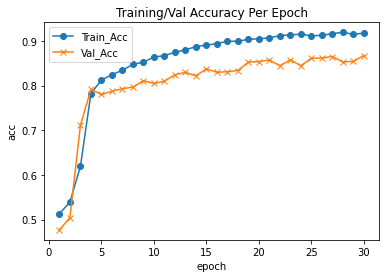

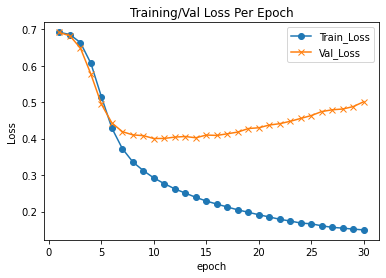

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.81      0.93      0.87      1217
    positive       0.93      0.81      0.86      1335

    accuracy                           0.87      2552
   macro avg       0.87      0.87      0.87      2552
weighted avg       0.88      0.87      0.87      2552


        ----------Validation Data------------------
Accuarcy: 86.71630094043887
Precision: 87.51 %
Recall-score: 86.72
F1-score: 86.69

-----------Confusion Matrix------------

[[1136   81]
 [ 258 1077]]


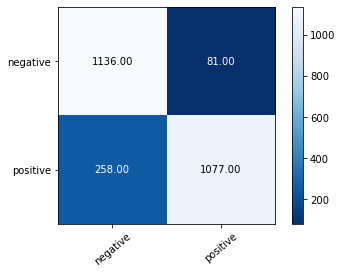

In [11]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
#labeling negative-0 positive-1 
y = le.fit_transform(sentiment)
# class names - like a dictionary negative means 0 positive means 1
label_names = le.classes_

trainmodelCNN(vect,y)

#### LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                77568     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 50)             23000     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              51        
Total params: 100,619
Trainable params: 100,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
12/12 [==============================] - 3s 54ms/step - loss: 0.6925 - accuracy: 0.5531 - val_loss

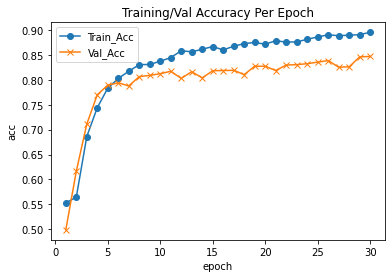

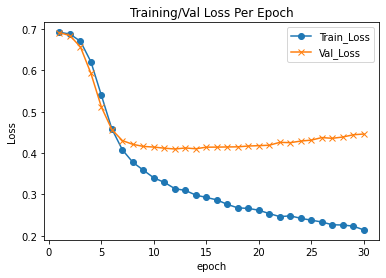

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.80      0.91      0.85      1217
    positive       0.90      0.79      0.84      1335

    accuracy                           0.85      2552
   macro avg       0.85      0.85      0.85      2552
weighted avg       0.85      0.85      0.85      2552


        ----------Validation Data------------------
Accuarcy: 84.67868338557993
Precision: 85.39 %
Recall-score: 84.68
F1-score: 84.66

-----------Confusion Matrix------------

[[1106  111]
 [ 280 1055]]


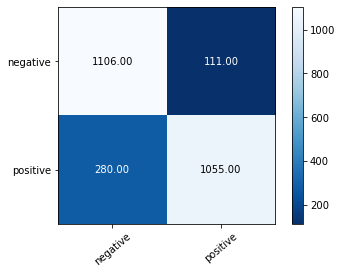

In [12]:
trainmodelLSTM(vect,y)

#### RCNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                77568     
_________________________________________________________________
reshape_2 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1024)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1024)          

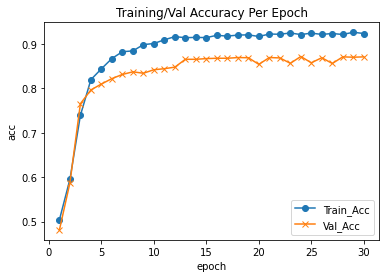

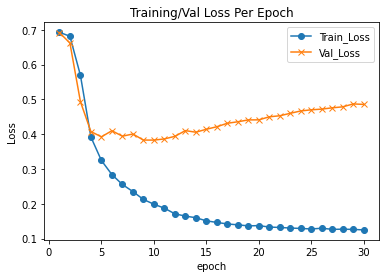

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1217
    positive       0.93      0.82      0.87      1335

    accuracy                           0.87      2552
   macro avg       0.87      0.87      0.87      2552
weighted avg       0.88      0.87      0.87      2552


        ----------Validation Data------------------
Accuarcy: 87.06896551724138
Precision: 87.75 %
Recall-score: 87.07
F1-score: 87.05

-----------Confusion Matrix------------

[[1133   84]
 [ 246 1089]]


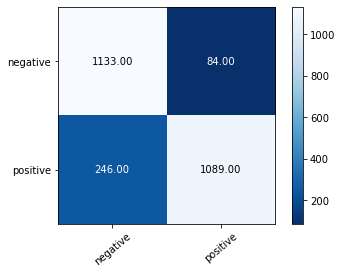

In [13]:
trainmodelRCNN(vect,y)

## AJGT Dataset

In [14]:
df = pd.read_csv('dataset/AJGT.csv')
df.head(5)

,ID,text,polarity
0,1,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...,Positive
1,2,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...,Negative
2,3,كله رائع بجد ربنا يكرمك,Positive
3,4,لسانك قذر يا قمامه,Negative
4,5,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...,Negative


In [15]:
text = df.text
sentiment = df.polarity
text = preprocess_text(text)

#### CNN

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                101568    
_________________________________________________________________
reshape_4 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

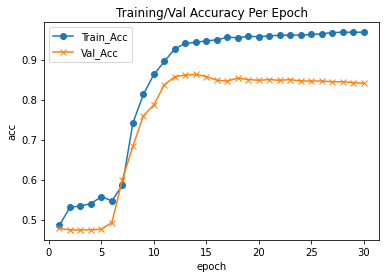

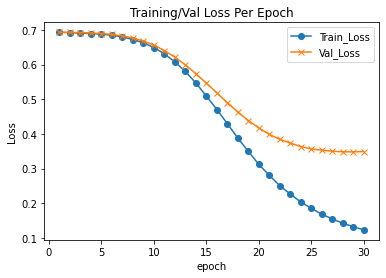

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    Negative       0.81      0.86      0.84       256
    Positive       0.87      0.82      0.84       284

    accuracy                           0.84       540
   macro avg       0.84      0.84      0.84       540
weighted avg       0.84      0.84      0.84       540


        ----------Validation Data------------------
Accuarcy: 84.07407407407408
Precision: 84.24 %
Recall-score: 84.07
F1-score: 84.08

-----------Confusion Matrix------------

[[221  35]
 [ 51 233]]


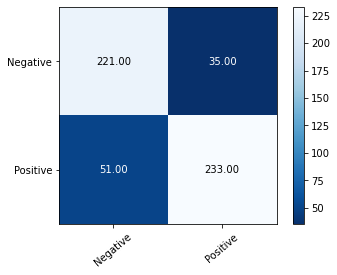

In [16]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodelCNN(vect,y)

#### LSTM

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                101568    
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 64)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             23000     
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1)              51        
Total params: 124,619
Trainable params: 124,619
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
3/3 [==============================] - 3s 252ms/step - loss: 0.6931 - accuracy: 0.5048 - val_loss:

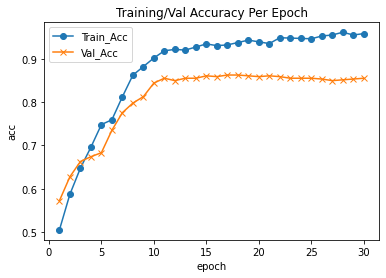

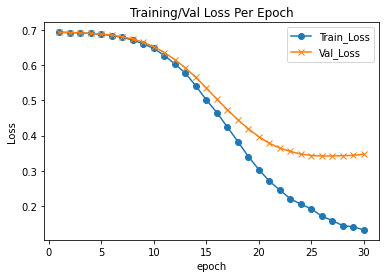

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85       256
    Positive       0.88      0.84      0.86       284

    accuracy                           0.86       540
   macro avg       0.86      0.86      0.86       540
weighted avg       0.86      0.86      0.86       540


        ----------Validation Data------------------
Accuarcy: 85.55555555555556
Precision: 85.69 %
Recall-score: 85.56
F1-score: 85.57

-----------Confusion Matrix------------

[[224  32]
 [ 46 238]]


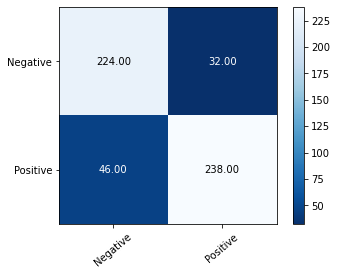

In [17]:
trainmodelLSTM(vect,y)

#### RCNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                101568    
_________________________________________________________________
reshape_6 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 1, 1024)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1024)          

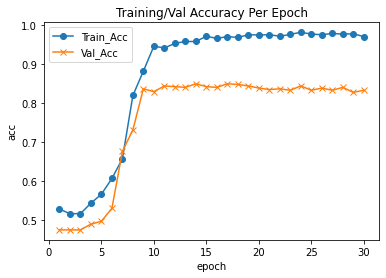

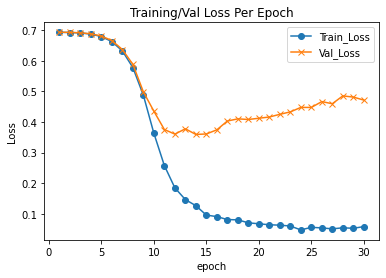

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82       256
    Positive       0.84      0.84      0.84       284

    accuracy                           0.83       540
   macro avg       0.83      0.83      0.83       540
weighted avg       0.83      0.83      0.83       540


        ----------Validation Data------------------
Accuarcy: 83.33333333333334
Precision: 83.33 %
Recall-score: 83.33
F1-score: 83.33

-----------Confusion Matrix------------

[[211  45]
 [ 45 239]]


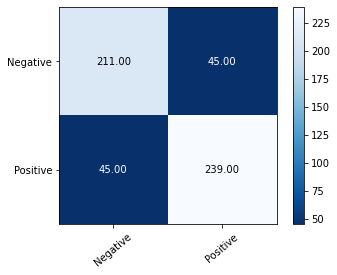

In [18]:
trainmodelRCNN(vect,y)

## ArTwitter Dataset

In [19]:
df = pd.read_csv('dataset/ArTwitter.csv')
df.head(5)

,sentiment,txt
0,positive,انشاء الله هنعمل حاجه
1,negative,اقسم باللله ان العرب اكثر الشعوب تخلفاا
2,negative,﻿هات ناس تفهم .. و المثل بحكي اسأل مجرب و لا ت...
3,negative,صرماتي براس اهلك
4,negative,حرام السخرية من الناس


In [20]:
text = df.txt
sentiment = df.sentiment
text = preprocess_text(text)

#### CNN

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                114176    
_________________________________________________________________
reshape_8 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

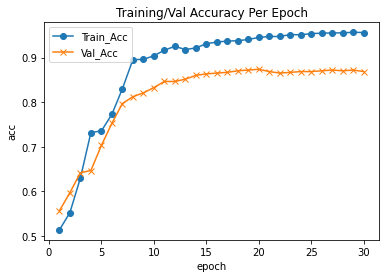

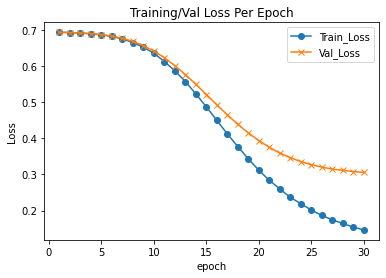

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87       283
    positive       0.91      0.83      0.87       303

    accuracy                           0.87       586
   macro avg       0.87      0.87      0.87       586
weighted avg       0.87      0.87      0.87       586


        ----------Validation Data------------------
Accuarcy: 86.86006825938567
Precision: 87.17 %
Recall-score: 86.86
F1-score: 86.86

-----------Confusion Matrix------------

[[257  26]
 [ 51 252]]


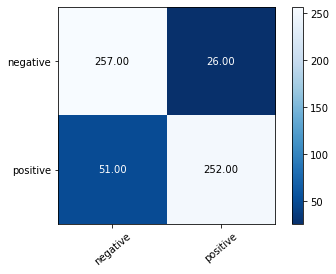

In [21]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodelCNN(vect,y)

#### LSTM

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                114176    
_________________________________________________________________
reshape_9 (Reshape)          (None, 1, 64)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 50)             23000     
_________________________________________________________________
dense_15 (Dense)             (None, 1, 1)              51        
Total params: 137,227
Trainable params: 137,227
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
3/3 [==============================] - 3s 280ms/step - loss: 0.6930 - accuracy: 0.5018 - val_loss:

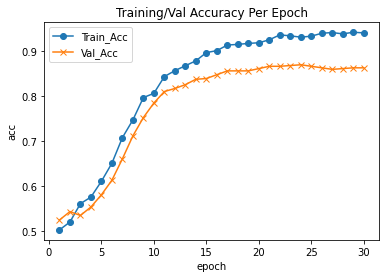

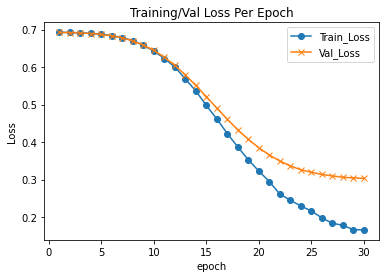

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87       283
    positive       0.91      0.82      0.86       303

    accuracy                           0.86       586
   macro avg       0.87      0.86      0.86       586
weighted avg       0.87      0.86      0.86       586


        ----------Validation Data------------------
Accuarcy: 86.3481228668942
Precision: 86.73 %
Recall-score: 86.35
F1-score: 86.34

-----------Confusion Matrix------------

[[257  26]
 [ 54 249]]


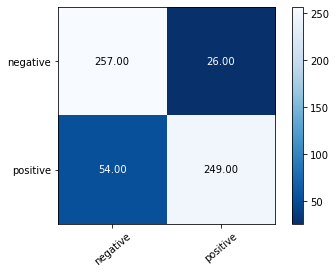

In [22]:
trainmodelLSTM(vect,y)

#### RCNN

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                114176    
_________________________________________________________________
reshape_10 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 1, 1024)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1024)          

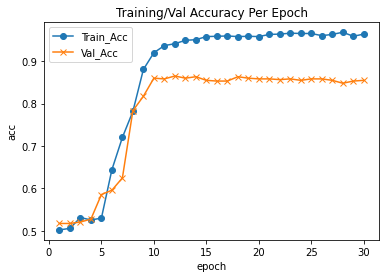

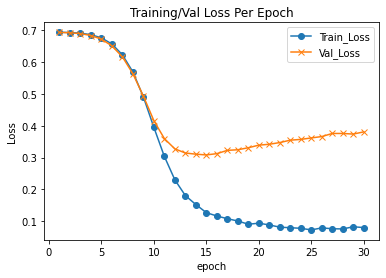

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.82      0.90      0.86       283
    positive       0.90      0.81      0.85       303

    accuracy                           0.85       586
   macro avg       0.86      0.86      0.85       586
weighted avg       0.86      0.85      0.85       586


        ----------Validation Data------------------
Accuarcy: 85.49488054607508
Precision: 85.89 %
Recall-score: 85.49
F1-score: 85.48

-----------Confusion Matrix------------

[[255  28]
 [ 57 246]]


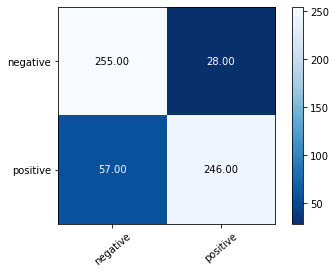

In [23]:
trainmodelRCNN(vect,y)